## DIABETES.csv


In [1]:
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from prefect import flow, task, get_run_logger
from typing import Callable
from functools import wraps
from io import StringIO
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import datasets

# Para representar el árbol de decisión
from six import StringIO  # Capa de compatibilidad entre Python 2 y Python 3
from sklearn.tree import export_graphviz # Visualización de árboles de decisión
from IPython.display import Image # Módulo de gestión de imágenes digitales 
import pydotplus # Envoltorio mejorado del lenguaje "dot" de graphviz 
from sklearn.metrics import classification_report

In [2]:
def timing_decorator(func: Callable) -> Callable:
    '''Custom decorator to time task execution'''
    @wraps(func)
    def wrapper(*args, **kwargs):
        logger = get_run_logger()
        start_time = time.time()

        # Execute the original function
        result = func(*args, **kwargs)

        end_time = time.time()
        execution_time = end_time - start_time

        logger.info(f"Task '{func.__name__}' completed in {execution_time:.2f} seconds")
        return result

    return wrapper

In [3]:
@task
@timing_decorator
def diabetes_dataset_retribution():
        # Se define el nombre de las columnas en una lista 
    nombre_columnas = ['Embarazos', 'Glucosa', 'Presion Arterial', 'Grosor Piel', 'Insulina', 'Indice Masa Corporal', 'Función de Pedigree', 'Edad', 'Etiqueta']

    # Se usa la biblioteca Pandas para cargar el dataset desde un archivo de texto 
    # "separado por comas" (CSV), usando los nombres de columna previamente definidos
    try:
        response = requests.get("https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv")
        response.raise_for_status()
        csv_data = StringIO(response.text)
        dataset = pd.read_csv(csv_data, header=1, names=nombre_columnas)
        print("Dataset cargado exitosamente.")
        print(dataset.head())
        return dataset
    except requests.exceptions.RequestException as e:
        print(f"Error al descargar el dataset: {e}")
        raise e
    except Exception as e:
        print(f"Error al cargar el dataset: {e}")
        raise e


In [4]:
@task
@timing_decorator
def iris_dataset_retribution():
    #Lectura de los datos
    df= pd.read_csv('iris.csv')
 
    # También se puede cargar desde el paquete sklearn.datasets
    #df = load_iris()
 
    # previsualización del dataset
    df.head(5)
 
    return df


In [5]:
@task
@timing_decorator
def cancer_dataset_retribution():
    dataset = datasets.load_breast_cancer()
    print("Características (X_i): ", dataset.feature_names)
 
    return dataset


In [6]:
@task
@timing_decorator
def iris_preprocessing(df):
    X_train, X_test, y_train, y_test = train_test_split(df[['SepalLengthCm', 'SepalWidthCm',
                                                        'PetalLengthCm', 'PetalWidthCm']],
                                                    df['Species'], random_state=0)
 
    print("Tamaño de X_train: {}\nTamaño de y_train: {}".format(X_train.shape, y_train.shape))
    print("Tamaño de X_test: {}\nTamaño de y_test: {}".format(X_test.shape, y_test.shape))
 
    return X_train, X_test, y_train, y_test

In [7]:
@task
@timing_decorator
def diabetes_preprocessing(dataset):
    feature_cols = ['Embarazos', 'Insulina', 'Indice Masa Corporal', 'Edad', 'Glucosa', 'Presion Arterial', 'Función de Pedigree']

    X = dataset[feature_cols] # Características
    y = dataset.Etiqueta # Variable objetivo

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% para entrenamiento
    print("Tamaño de X_train: {}\nTamaño de y_train: {}".format(X_train.shape, y_train.shape)) #Salida con formato en Python
    print("Tamaño de X_test: {}\nTamaño de y_test: {}".format(X_test.shape, y_test.shape))
    return X_train, X_test, y_train, y_test

In [8]:
@task
@timing_decorator
def cancer_preprocessing(dataset):
    X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.3,random_state=109)
 
    print("Tamaño de X_train: {}\nTamaño de y_train: {}".format(X_train.shape, y_train.shape))
    print("Tamaño de X_test: {}\nTamaño de y_test: {}".format(X_test.shape, y_test.shape))
 
    return X_train, X_test, y_train, y_test

In [9]:
@task
@timing_decorator
def decision_tree(X_train, X_test, y_train, y_test):
    dtree = DecisionTreeClassifier()

    # Entrenamiento
    dtree = dtree.fit(X_train, y_train)

    # Predicción para evaluación
    y_pred = dtree.predict(X_test)

    # Verificar si X_test es un DataFrame o un array numpy
    if hasattr(X_test, 'index'):
        # Es un DataFrame de pandas
        resultado_comparacion = pd.concat([X_test, y_test, pd.Series(y_pred, name='Predicción', index=X_test.index)], 
              ignore_index=False, axis=1)
    else:
        # Es un array de numpy - convertir a DataFrame
        if hasattr(X_train, 'columns'):
            # Si X_train tiene columnas, usar esos nombres
            column_names = X_train.columns.tolist()
        else:
            # Generar nombres de columnas genéricos
            column_names = [f'feature_{i}' for i in range(X_test.shape[1])]
        
        X_test_df = pd.DataFrame(X_test, columns=column_names)
        y_test_series = pd.Series(y_test, name='Actual')
        y_pred_series = pd.Series(y_pred, name='Predicción')
        
        resultado_comparacion = pd.concat([X_test_df, y_test_series, y_pred_series], axis=1)
    
    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())

    cv_scores = cross_val_score(dtree, X_train, y_train, cv=5)

    # Escribe en pantalla los desempeños ("accuracy") para cada "pliegue" (fold)
    print("Resultados de la validación cruzada en decision tree: ", cv_scores)

    # Escribe en pantalla el promedio de la métrica "accuracy" en el entrenamiento 
    print("Resultado promedio de la validación cruzada en decision tree:", np.average(cv_scores))

    # Escribe en pantalla la métrica "accuracy" para prueba (datos no usados en el entrenamiento)
    print("Exactitud (accuracy) en prueba (testing) del decision tree:", metrics.accuracy_score(y_test, y_pred))

    return dtree, y_pred

In [10]:
@task
@timing_decorator
def roc_curve_analysis(dtree, X_test, y_test, y_pred):
    fpr,tpr,_r=metrics.roc_curve(y_test,y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    print(roc_auc)
    metrics.RocCurveDisplay.from_estimator(dtree, X_test, y_test)

In [11]:
@task
@timing_decorator
def random_forest(X_train, X_test, y_train, y_test):
    # Create a Random Forest Classifier instance 
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    rf_predictions = rf_model.predict(X_test)

    # Evaluate the model 
    rf_accuracy = accuracy_score(y_test, rf_predictions) 
    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

    return rf_model

In [12]:
@task
@timing_decorator
def knn(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
 
    y_pred = knn.predict(X_test)
    
    # Verificar si X_test es un DataFrame o un array numpy
    if hasattr(X_test, 'index'):
        # Es un DataFrame de pandas
        resultado_comparacion = pd.concat([X_test, y_test, pd.Series(y_pred, name='Predicción', index=X_test.index)],
                ignore_index=False, axis=1)
    else:
        # Es un array de numpy - convertir a DataFrame
        if hasattr(X_train, 'columns'):
            column_names = X_train.columns.tolist()
        else:
            column_names = [f'feature_{i}' for i in range(X_test.shape[1])]
        
        X_test_df = pd.DataFrame(X_test, columns=column_names)
        y_test_series = pd.Series(y_test, name='Actual')
        y_pred_series = pd.Series(y_pred, name='Predicción')
        
        resultado_comparacion = pd.concat([X_test_df, y_test_series, y_pred_series], axis=1)
    
    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())
    
    print("Score sobre el conjunto de test: {:.3f}".format(knn.score(X_test, y_test)))
 
    np.set_printoptions(precision=2)
    #Validación cruzada datos entrenamiento 
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
    print(cv_scores)
 
    print("Desempeño promedio del kNN:")
    print(np.average(cv_scores))
 
    print("Exactitud (accuracy) en prueba (testing) del kNN:", metrics.accuracy_score(y_test, y_pred))
  
    return knn

In [13]:
@task
def knn_scaler(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    x_train_scaler = scaler.fit_transform(X_train)
    x_test_scaler = scaler.transform(X_test)
 
    knn_scaled = KNeighborsClassifier(n_neighbors=1)
    knn_scaled.fit(x_train_scaler, y_train)
 
    y_pred = knn_scaled.predict(x_test_scaler)
 
    # Crear DataFrame para mostrar comparación
    if hasattr(X_test, 'index'):
        comparacion_df = pd.concat([X_test,
                                   y_test,
                                   pd.Series(y_pred, name='Predicción', index=X_test.index)],
                                  ignore_index=False, axis=1)
    else:
        if hasattr(X_train, 'columns'):
            column_names = X_train.columns.tolist()
        else:
            column_names = [f'feature_{i}' for i in range(X_test.shape[1])]
        
        X_test_df = pd.DataFrame(X_test, columns=column_names)
        y_test_series = pd.Series(y_test, name='Actual')
        y_pred_series = pd.Series(y_pred, name='Predicción')
        
        comparacion_df = pd.concat([X_test_df, y_test_series, y_pred_series], axis=1)
    
    print("Comparación de predicciones:")
    print(comparacion_df.head())
 
    print("Score sobre el conjunto de test: {:.3f}".format(knn_scaled.score(x_test_scaler, y_test)))
 
    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(knn_scaled, x_train_scaler, y_train, cv=5)
    print(cv_scores)
 
    print("Desempeño promedio:")
    print(np.average(cv_scores))
 
    print("Exactitud (accuracy) en prueba (testing):", metrics.accuracy_score(y_test, y_pred))
 
    return knn_scaled


In [14]:
@task
@timing_decorator
def svm(X_train, X_test, y_train, y_test):
    svm_class = SVC(kernel='rbf', random_state=0)
    svm_class.fit(X_train, y_train)
 
    y_pred = svm_class.predict(X_test)
 
    # Verificar si X_test es un DataFrame o un array numpy
    if hasattr(X_test, 'index'):
        resultado_comparacion = pd.concat([X_test, y_test, pd.Series(y_pred, name='Predicción', index=X_test.index)],
                ignore_index=False, axis=1)
    else:
        if hasattr(X_train, 'columns'):
            column_names = X_train.columns.tolist()
        else:
            column_names = [f'feature_{i}' for i in range(X_test.shape[1])]
        
        X_test_df = pd.DataFrame(X_test, columns=column_names)
        y_test_series = pd.Series(y_test, name='Actual')
        y_pred_series = pd.Series(y_pred, name='Predicción')
        
        resultado_comparacion = pd.concat([X_test_df, y_test_series, y_pred_series], axis=1)
    
    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())
   
    print("Score de entrenamiento: {:.3f}".format(svm_class.score(X_train, y_train)))
    print("Score de test: {:.3f}".format(svm_class.score(X_test, y_test)))
 
    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(svm_class, X_train, y_train, cv=5)
    print("Scores de validación cruzada:")
    print(cv_scores)
 
    print("Desempeño promedio:")
    print(np.average(cv_scores))
 
    print("Accuracy en el testing:", metrics.accuracy_score(y_test, y_pred))

    return svm_class


In [15]:
@task
@timing_decorator
def svm_scaler(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    x_train_scaler = scaler.fit_transform(X_train)
    x_test_scaler = scaler.transform(X_test)
 
    svm_class_scaled = SVC(kernel='rbf', random_state=0)
    svm_class_scaled.fit(x_train_scaler, y_train)
 
    y_pred = svm_class_scaled.predict(x_test_scaler)
 
    # Verificar si X_test es un DataFrame o un array numpy
    if hasattr(X_test, 'index'):
        resultado_comparacion = pd.concat([X_test, y_test, pd.Series(y_pred, name='Predicción', index=X_test.index)],
                ignore_index=False, axis=1)
    else:
        if hasattr(X_train, 'columns'):
            column_names = X_train.columns.tolist()
        else:
            column_names = [f'feature_{i}' for i in range(X_test.shape[1])]
        
        X_test_df = pd.DataFrame(X_test, columns=column_names)
        y_test_series = pd.Series(y_test, name='Actual')
        y_pred_series = pd.Series(y_pred, name='Predicción')
        
        resultado_comparacion = pd.concat([X_test_df, y_test_series, y_pred_series], axis=1)
    
    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())
   
    print("Score de entrenamiento: {:.3f}".format(svm_class_scaled.score(x_train_scaler, y_train)))
    print("Score de test: {:.3f}".format(svm_class_scaled.score(x_test_scaler, y_test)))
 
    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(svm_class_scaled, x_train_scaler, y_train, cv=5)
    print("Scores de validación cruzada:")
    print(cv_scores)
 
    print("Desempeño promedio:")
    print(np.average(cv_scores))
 
    print("Accuracy en el testing:", metrics.accuracy_score(y_test, y_pred))
 
    return svm_class_scaled

In [16]:
@task
@timing_decorator
def confusion_matrix(class_names, model, X_test, y_test):
 
    print("Visualización de desempeño con Matriz de Confusión:")
  
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=None
    )
 
    disp.ax_.set_title("Confusion Matrix")
    print("Confusion Matrix")
    print(disp.confusion_matrix)
 
    plt.show()

In [17]:
@task
@timing_decorator
def show_classificationreport(model, X_test, y_test, class_names):
    
    y_pred = model.predict(X_test)

    print("Clasification Report")
    report = classification_report(y_test, y_pred, target_names=class_names)
    print(report)
    
    return report

20:27:43.527 | INFO    | prefect - Starting temporary server on http://127.0.0.1:8486
See https://docs.prefect.io/v3/concepts/server#how-to-guides for more information on running a dedicated Prefect server.

20:27:48.061 | INFO    | Flow run 'sophisticated-foxhound' - Beginning flow run 'sophisticated-foxhound' for flow 'iris-flow'

20:27:48.117 | INFO    | Task run 'iris_dataset_retribution-7d8' - Task 'iris_dataset_retribution' completed in 0.00 seconds

20:27:48.119 | INFO    | Task run 'iris_dataset_retribution-7d8' - Finished in state Completed()

Tamaño de X_train: (112, 4)
Tamaño de y_train: (112,)
Tamaño de X_test: (38, 4)
Tamaño de y_test: (38,)


20:27:48.178 | INFO    | Task run 'iris_preprocessing-c93' - Task 'iris_preprocessing' completed in 0.00 seconds

20:27:48.181 | INFO    | Task run 'iris_preprocessing-c93' - Finished in state Completed()

Comparación de predicciones (primeras 5 filas):
     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
114            5.8           2.8            5.1           2.4   
62             6.0           2.2            4.0           1.0   
33             5.5           4.2            1.4           0.2   
107            7.3           2.9            6.3           1.8   
7              5.0           3.4            1.5           0.2   

             Species       Predicción  
114   Iris-virginica   Iris-virginica  
62   Iris-versicolor  Iris-versicolor  
33       Iris-setosa      Iris-setosa  
107   Iris-virginica   Iris-virginica  
7        Iris-setosa      Iris-setosa  
Resultados de la validación cruzada en decision tree:  [0.95652174 0.95652174 1.         0.90909091 0.95454545]
Resultado promedio de la validación cruzada en decision tree: 0.9553359683794467
Exactitud (accuracy) en prueba (testing) del decision tree: 0.9736842105263158


20:27:48.256 | INFO    | Task run 'decision_tree-98f' - Task 'decision_tree' completed in 0.03 seconds

20:27:48.256 | INFO    | Task run 'decision_tree-98f' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]


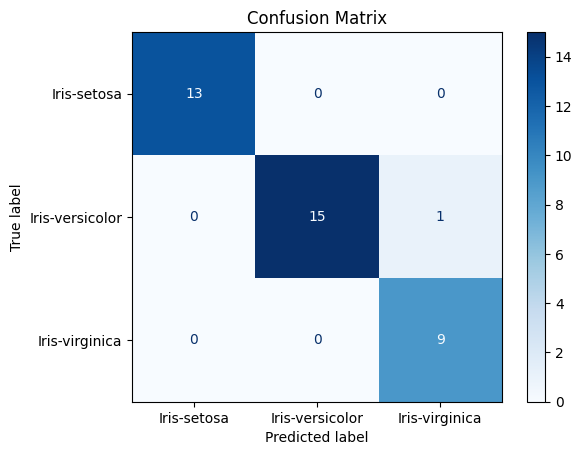

20:27:48.438 | INFO    | Task run 'confusion_matrix-524' - Task 'confusion_matrix' completed in 0.14 seconds

20:27:48.438 | INFO    | Task run 'confusion_matrix-524' - Finished in state Completed()

Clasification Report
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      0.94      0.97        16
 Iris-virginica       0.90      1.00      0.95         9

       accuracy                           0.97        38
      macro avg       0.97      0.98      0.97        38
   weighted avg       0.98      0.97      0.97        38



20:27:48.482 | INFO    | Task run 'show_classificationreport-465' - Task 'show_classificationreport' completed in 0.01 seconds

20:27:48.486 | INFO    | Task run 'show_classificationreport-465' - Finished in state Completed()

Random Forest Accuracy: 0.9737


20:27:48.640 | INFO    | Task run 'random_forest-d6f' - Task 'random_forest' completed in 0.12 seconds

20:27:48.645 | INFO    | Task run 'random_forest-d6f' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]


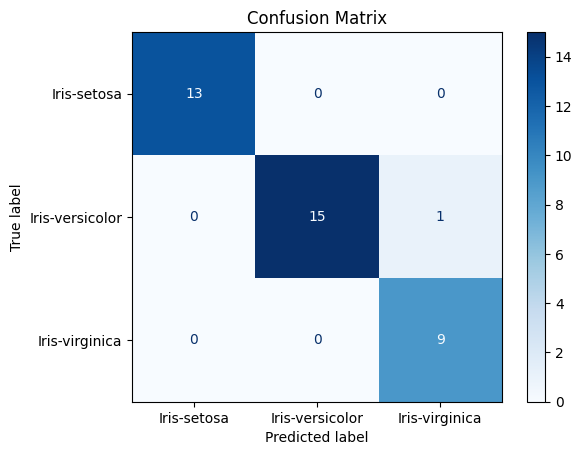

20:27:48.785 | INFO    | Task run 'confusion_matrix-899' - Task 'confusion_matrix' completed in 0.11 seconds

20:27:48.785 | INFO    | Task run 'confusion_matrix-899' - Finished in state Completed()

Clasification Report
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      0.94      0.97        16
 Iris-virginica       0.90      1.00      0.95         9

       accuracy                           0.97        38
      macro avg       0.97      0.98      0.97        38
   weighted avg       0.98      0.97      0.97        38



20:27:48.832 | INFO    | Task run 'show_classificationreport-fea' - Task 'show_classificationreport' completed in 0.01 seconds

20:27:48.837 | INFO    | Task run 'show_classificationreport-fea' - Finished in state Completed()

Comparación de predicciones (primeras 5 filas):
     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
114            5.8           2.8            5.1           2.4   
62             6.0           2.2            4.0           1.0   
33             5.5           4.2            1.4           0.2   
107            7.3           2.9            6.3           1.8   
7              5.0           3.4            1.5           0.2   

             Species       Predicción  
114   Iris-virginica   Iris-virginica  
62   Iris-versicolor  Iris-versicolor  
33       Iris-setosa      Iris-setosa  
107   Iris-virginica   Iris-virginica  
7        Iris-setosa      Iris-setosa  
Score sobre el conjunto de test: 0.974
[0.96 0.91 1.   0.91 0.95]
Desempeño promedio del kNN:
0.9466403162055336
Exactitud (accuracy) en prueba (testing) del kNN: 0.9736842105263158


20:27:48.896 | INFO    | Task run 'knn-54d' - Task 'knn' completed in 0.04 seconds

20:27:48.905 | INFO    | Task run 'knn-54d' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]


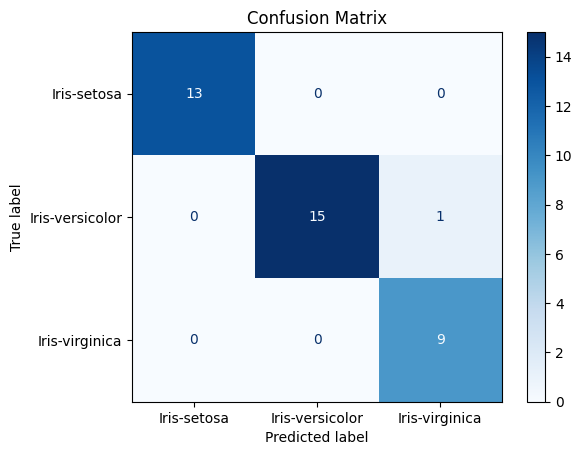

20:27:49.025 | INFO    | Task run 'confusion_matrix-1a8' - Task 'confusion_matrix' completed in 0.10 seconds

20:27:49.042 | INFO    | Task run 'confusion_matrix-1a8' - Finished in state Completed()

Clasification Report
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      0.94      0.97        16
 Iris-virginica       0.90      1.00      0.95         9

       accuracy                           0.97        38
      macro avg       0.97      0.98      0.97        38
   weighted avg       0.98      0.97      0.97        38



20:27:49.073 | INFO    | Task run 'show_classificationreport-d01' - Task 'show_classificationreport' completed in 0.01 seconds

20:27:49.078 | INFO    | Task run 'show_classificationreport-d01' - Finished in state Completed()

Comparación de predicciones:
     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
114            5.8           2.8            5.1           2.4   
62             6.0           2.2            4.0           1.0   
33             5.5           4.2            1.4           0.2   
107            7.3           2.9            6.3           1.8   
7              5.0           3.4            1.5           0.2   

             Species       Predicción  
114   Iris-virginica   Iris-virginica  
62   Iris-versicolor  Iris-versicolor  
33       Iris-setosa      Iris-setosa  
107   Iris-virginica   Iris-virginica  
7        Iris-setosa      Iris-setosa  
Score sobre el conjunto de test: 0.921
[0.96 0.91 0.95 0.91 0.95]
Desempeño promedio:
0.9375494071146246
Exactitud (accuracy) en prueba (testing): 0.9210526315789473


20:27:49.135 | INFO    | Task run 'knn_scaler-814' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[ 0  0 13]
 [ 0  0 16]
 [ 0  0  9]]


c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


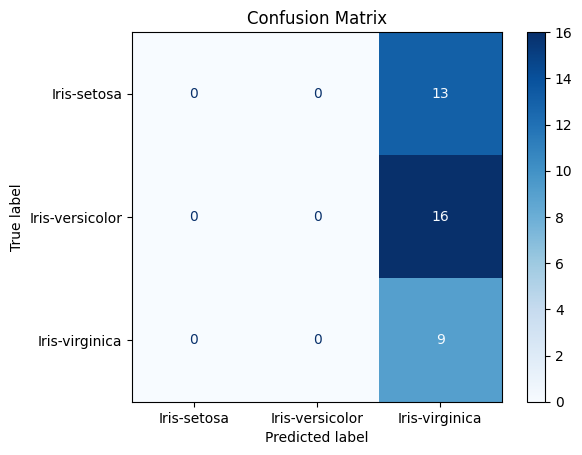

20:27:49.291 | INFO    | Task run 'confusion_matrix-166' - Task 'confusion_matrix' completed in 0.12 seconds

20:27:49.296 | INFO    | Task run 'confusion_matrix-166' - Finished in state Completed()

Clasification Report
                 precision    recall  f1-score   support

    Iris-setosa       0.00      0.00      0.00        13
Iris-versicolor       0.00      0.00      0.00        16
 Iris-virginica       0.24      1.00      0.38         9

       accuracy                           0.24        38
      macro avg       0.08      0.33      0.13        38
   weighted avg       0.06      0.24      0.09        38



c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\metrics\_classification.py:

20:27:49.329 | INFO    | Task run 'show_classificationreport-a34' - Task 'show_classificationreport' completed in 0.01 seconds

20:27:49.334 | INFO    | Task run 'show_classificationreport-a34' - Finished in state Completed()

Comparación de predicciones (primeras 5 filas):
     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
114            5.8           2.8            5.1           2.4   
62             6.0           2.2            4.0           1.0   
33             5.5           4.2            1.4           0.2   
107            7.3           2.9            6.3           1.8   
7              5.0           3.4            1.5           0.2   

             Species       Predicción  
114   Iris-virginica   Iris-virginica  
62   Iris-versicolor  Iris-versicolor  
33       Iris-setosa      Iris-setosa  
107   Iris-virginica   Iris-virginica  
7        Iris-setosa      Iris-setosa  
Score de entrenamiento: 0.964
Score de test: 0.974
Scores de validación cruzada:
[1.   0.96 1.   0.91 0.95]
Desempeño promedio:
0.9640316205533598
Accuracy en el testing: 0.9736842105263158


20:27:49.402 | INFO    | Task run 'svm-4b9' - Task 'svm' completed in 0.04 seconds

20:27:49.407 | INFO    | Task run 'svm-4b9' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]


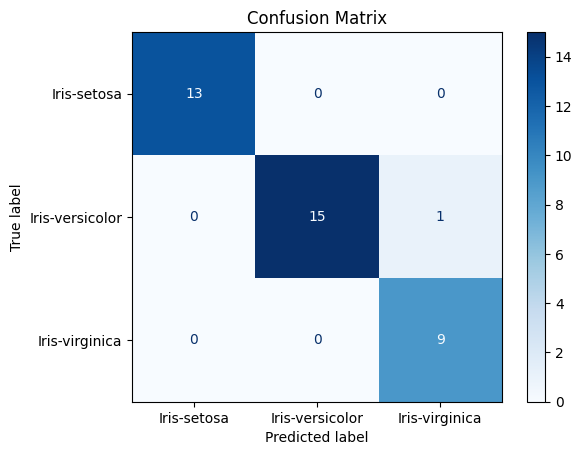

20:27:49.546 | INFO    | Task run 'confusion_matrix-0da' - Task 'confusion_matrix' completed in 0.12 seconds

20:27:49.552 | INFO    | Task run 'confusion_matrix-0da' - Finished in state Completed()

Clasification Report
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      0.94      0.97        16
 Iris-virginica       0.90      1.00      0.95         9

       accuracy                           0.97        38
      macro avg       0.97      0.98      0.97        38
   weighted avg       0.98      0.97      0.97        38



20:27:49.585 | INFO    | Task run 'show_classificationreport-760' - Task 'show_classificationreport' completed in 0.01 seconds

20:27:49.590 | INFO    | Task run 'show_classificationreport-760' - Finished in state Completed()

Comparación de predicciones (primeras 5 filas):
     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
114            5.8           2.8            5.1           2.4   
62             6.0           2.2            4.0           1.0   
33             5.5           4.2            1.4           0.2   
107            7.3           2.9            6.3           1.8   
7              5.0           3.4            1.5           0.2   

             Species       Predicción  
114   Iris-virginica   Iris-virginica  
62   Iris-versicolor  Iris-versicolor  
33       Iris-setosa      Iris-setosa  
107   Iris-virginica   Iris-virginica  
7        Iris-setosa      Iris-setosa  
Score de entrenamiento: 0.973
Score de test: 0.974
Scores de validación cruzada:
[0.96 0.87 1.   0.95 1.  ]
Desempeño promedio:
0.9561264822134387
Accuracy en el testing: 0.9736842105263158


20:27:49.652 | INFO    | Task run 'svm_scaler-44f' - Task 'svm_scaler' completed in 0.03 seconds

20:27:49.658 | INFO    | Task run 'svm_scaler-44f' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[ 0  0 13]
 [ 0  0 16]
 [ 0  0  9]]


c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


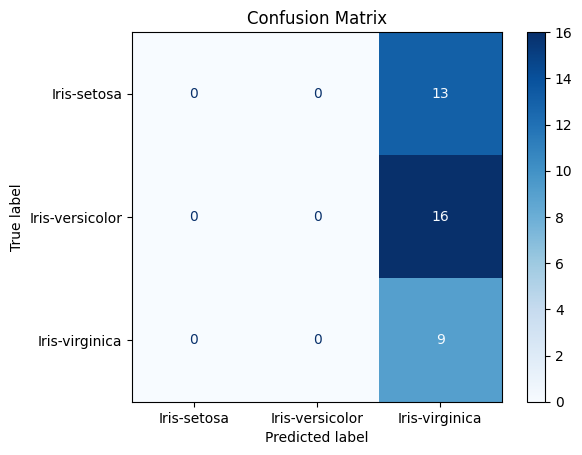

20:27:49.799 | INFO    | Task run 'confusion_matrix-9d9' - Task 'confusion_matrix' completed in 0.12 seconds

20:27:49.805 | INFO    | Task run 'confusion_matrix-9d9' - Finished in state Completed()

Clasification Report
                 precision    recall  f1-score   support

    Iris-setosa       0.00      0.00      0.00        13
Iris-versicolor       0.00      0.00      0.00        16
 Iris-virginica       0.24      1.00      0.38         9

       accuracy                           0.24        38
      macro avg       0.08      0.33      0.13        38
   weighted avg       0.06      0.24      0.09        38



c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMe

20:27:49.836 | INFO    | Task run 'show_classificationreport-d53' - Task 'show_classificationreport' completed in 0.01 seconds

20:27:49.841 | INFO    | Task run 'show_classificationreport-d53' - Finished in state Completed()

20:27:49.919 | INFO    | Flow run 'sophisticated-foxhound' - Finished in state Completed()

In [18]:
@flow
def iris_flow():
    df = iris_dataset_retribution()
    X_train, X_test, y_train, y_test = iris_preprocessing(df)
    
    class_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    
    dtree_model, y_pred = decision_tree(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, dtree_model, X_test, y_test)
    show_classificationreport(dtree_model, X_test, y_test, class_names)

    rf_model =random_forest(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, rf_model, X_test, y_test)
    show_classificationreport(rf_model, X_test, y_test, class_names)

    knn_model = knn(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, knn_model, X_test, y_test)
    show_classificationreport(knn_model, X_test, y_test, class_names)

    knn_scaled = knn_scaler(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, knn_scaled, X_test, y_test)
    show_classificationreport(knn_scaled, X_test, y_test, class_names)

    svm_class_model = svm(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, svm_class_model, X_test, y_test)
    show_classificationreport(svm_class_model, X_test, y_test, class_names)

    svm_class_scaled = svm_scaler(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, svm_class_scaled, X_test, y_test)
    show_classificationreport(svm_class_scaled, X_test, y_test, class_names)
    
iris_flow()

20:29:29.151 | INFO    | Flow run 'small-iguana' - Beginning flow run 'small-iguana' for flow 'cancer-flow'

Características (X_i):  ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


20:29:29.176 | INFO    | Task run 'cancer_dataset_retribution-de2' - Task 'cancer_dataset_retribution' completed in 0.00 seconds

20:29:29.181 | INFO    | Task run 'cancer_dataset_retribution-de2' - Finished in state Completed()

Tamaño de X_train: (398, 30)
Tamaño de y_train: (398,)
Tamaño de X_test: (171, 30)
Tamaño de y_test: (171,)


20:29:29.203 | INFO    | Task run 'cancer_preprocessing-8ae' - Task 'cancer_preprocessing' completed in 0.00 seconds

20:29:29.208 | INFO    | Task run 'cancer_preprocessing-8ae' - Finished in state Completed()

Comparación de predicciones (primeras 5 filas):
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0      11.67      20.02      75.21      416.2    0.10160    0.09453   
1      11.94      18.24      75.71      437.6    0.08261    0.04751   
2      19.16      26.60     126.20     1138.0    0.10200    0.14530   
3      19.55      28.77     133.60     1207.0    0.09260    0.20630   
4      12.47      18.60      81.09      481.9    0.09965    0.10580   

   feature_6  feature_7  feature_8  feature_9  ...  feature_22  feature_23  \
0    0.04200    0.02157     0.1859    0.06461  ...       87.00       550.6   
1    0.01972    0.01349     0.1868    0.06110  ...       83.67       527.2   
2    0.19210    0.09664     0.1902    0.06220  ...      159.80      1724.0   
3    0.17840    0.11440     0.1893    0.06232  ...      178.60      1926.0   
4    0.08005    0.03821     0.1925    0.06373  ...       96.05       677.9   

   feature_24  feature_25  feature_26  feature_27  featu

20:29:29.276 | INFO    | Task run 'decision_tree-8ac' - Task 'decision_tree' completed in 0.05 seconds

20:29:29.281 | INFO    | Task run 'decision_tree-8ac' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[ 58   5]
 [  3 105]]


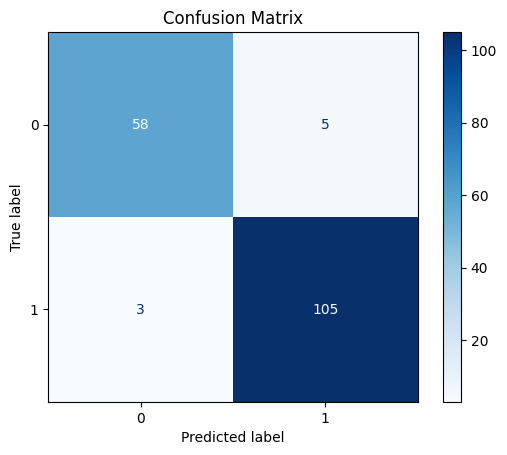

20:29:29.394 | INFO    | Task run 'confusion_matrix-8a5' - Task 'confusion_matrix' completed in 0.09 seconds

20:29:29.398 | INFO    | Task run 'confusion_matrix-8a5' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.95      0.92      0.94        63
           1       0.95      0.97      0.96       108

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



20:29:29.425 | INFO    | Task run 'show_classificationreport-552' - Task 'show_classificationreport' completed in 0.01 seconds

20:29:29.431 | INFO    | Task run 'show_classificationreport-552' - Finished in state Completed()

Random Forest Accuracy: 0.9766


20:29:29.595 | INFO    | Task run 'random_forest-03d' - Task 'random_forest' completed in 0.14 seconds

20:29:29.595 | INFO    | Task run 'random_forest-03d' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[ 59   4]
 [  0 108]]


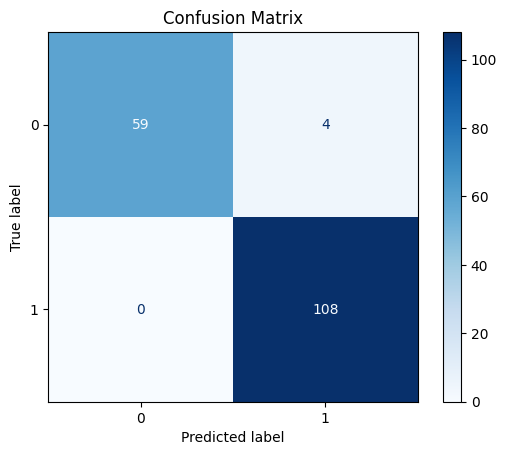

20:29:29.722 | INFO    | Task run 'confusion_matrix-678' - Task 'confusion_matrix' completed in 0.09 seconds

20:29:29.729 | INFO    | Task run 'confusion_matrix-678' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        63
           1       0.96      1.00      0.98       108

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



20:29:29.764 | INFO    | Task run 'show_classificationreport-b67' - Task 'show_classificationreport' completed in 0.01 seconds

20:29:29.769 | INFO    | Task run 'show_classificationreport-b67' - Finished in state Completed()

Comparación de predicciones (primeras 5 filas):
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0      11.67      20.02      75.21      416.2    0.10160    0.09453   
1      11.94      18.24      75.71      437.6    0.08261    0.04751   
2      19.16      26.60     126.20     1138.0    0.10200    0.14530   
3      19.55      28.77     133.60     1207.0    0.09260    0.20630   
4      12.47      18.60      81.09      481.9    0.09965    0.10580   

   feature_6  feature_7  feature_8  feature_9  ...  feature_22  feature_23  \
0    0.04200    0.02157     0.1859    0.06461  ...       87.00       550.6   
1    0.01972    0.01349     0.1868    0.06110  ...       83.67       527.2   
2    0.19210    0.09664     0.1902    0.06220  ...      159.80      1724.0   
3    0.17840    0.11440     0.1893    0.06232  ...      178.60      1926.0   
4    0.08005    0.03821     0.1925    0.06373  ...       96.05       677.9   

   feature_24  feature_25  feature_26  feature_27  featu

20:29:31.600 | INFO    | Task run 'knn-2bb' - Task 'knn' completed in 1.82 seconds

20:29:31.600 | INFO    | Task run 'knn-2bb' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[ 57   6]
 [  4 104]]


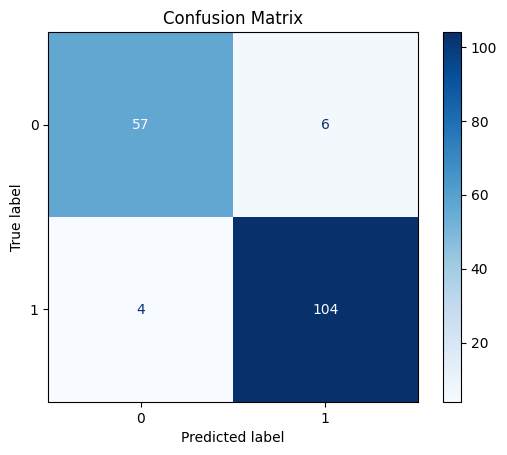

20:29:31.704 | INFO    | Task run 'confusion_matrix-953' - Task 'confusion_matrix' completed in 0.08 seconds

20:29:31.704 | INFO    | Task run 'confusion_matrix-953' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        63
           1       0.95      0.96      0.95       108

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171



20:29:31.746 | INFO    | Task run 'show_classificationreport-055' - Task 'show_classificationreport' completed in 0.01 seconds

20:29:31.752 | INFO    | Task run 'show_classificationreport-055' - Finished in state Completed()

Comparación de predicciones:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0      11.67      20.02      75.21      416.2    0.10160    0.09453   
1      11.94      18.24      75.71      437.6    0.08261    0.04751   
2      19.16      26.60     126.20     1138.0    0.10200    0.14530   
3      19.55      28.77     133.60     1207.0    0.09260    0.20630   
4      12.47      18.60      81.09      481.9    0.09965    0.10580   

   feature_6  feature_7  feature_8  feature_9  ...  feature_22  feature_23  \
0    0.04200    0.02157     0.1859    0.06461  ...       87.00       550.6   
1    0.01972    0.01349     0.1868    0.06110  ...       83.67       527.2   
2    0.19210    0.09664     0.1902    0.06220  ...      159.80      1724.0   
3    0.17840    0.11440     0.1893    0.06232  ...      178.60      1926.0   
4    0.08005    0.03821     0.1925    0.06373  ...       96.05       677.9   

   feature_24  feature_25  feature_26  feature_27  feature_28  feature_29  

20:29:31.814 | INFO    | Task run 'knn_scaler-db6' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[ 63   0]
 [108   0]]


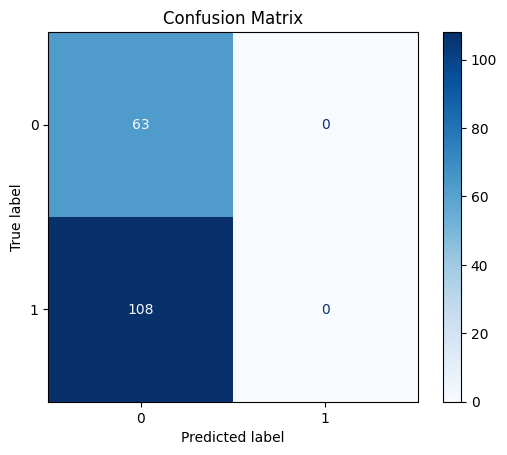

20:29:31.934 | INFO    | Task run 'confusion_matrix-cca' - Task 'confusion_matrix' completed in 0.09 seconds

20:29:31.943 | INFO    | Task run 'confusion_matrix-cca' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.37      1.00      0.54        63
           1       0.00      0.00      0.00       108

    accuracy                           0.37       171
   macro avg       0.18      0.50      0.27       171
weighted avg       0.14      0.37      0.20       171



c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

20:29:31.978 | INFO    | Task run 'show_classificationreport-d1a' - Task 'show_classificationreport' completed in 0.01 seconds

20:29:31.983 | INFO    | Task run 'show_classificationreport-d1a' - Finished in state Completed()

Comparación de predicciones (primeras 5 filas):
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0      11.67      20.02      75.21      416.2    0.10160    0.09453   
1      11.94      18.24      75.71      437.6    0.08261    0.04751   
2      19.16      26.60     126.20     1138.0    0.10200    0.14530   
3      19.55      28.77     133.60     1207.0    0.09260    0.20630   
4      12.47      18.60      81.09      481.9    0.09965    0.10580   

   feature_6  feature_7  feature_8  feature_9  ...  feature_22  feature_23  \
0    0.04200    0.02157     0.1859    0.06461  ...       87.00       550.6   
1    0.01972    0.01349     0.1868    0.06110  ...       83.67       527.2   
2    0.19210    0.09664     0.1902    0.06220  ...      159.80      1724.0   
3    0.17840    0.11440     0.1893    0.06232  ...      178.60      1926.0   
4    0.08005    0.03821     0.1925    0.06373  ...       96.05       677.9   

   feature_24  feature_25  feature_26  feature_27  featu

20:29:32.051 | INFO    | Task run 'svm-664' - Task 'svm' completed in 0.04 seconds

20:29:32.059 | INFO    | Task run 'svm-664' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[ 50  13]
 [  0 108]]


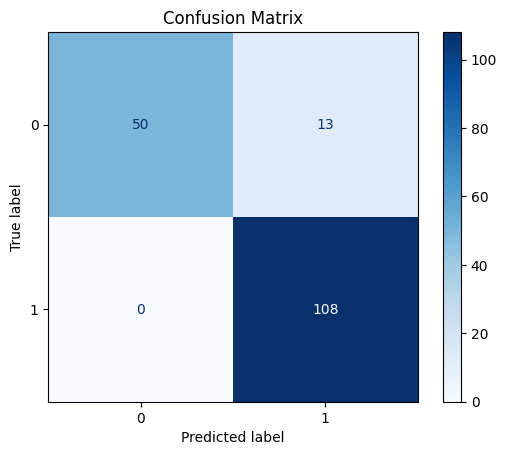

20:29:32.162 | INFO    | Task run 'confusion_matrix-00b' - Task 'confusion_matrix' completed in 0.08 seconds

20:29:32.178 | INFO    | Task run 'confusion_matrix-00b' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        63
           1       0.89      1.00      0.94       108

    accuracy                           0.92       171
   macro avg       0.95      0.90      0.91       171
weighted avg       0.93      0.92      0.92       171



20:29:32.206 | INFO    | Task run 'show_classificationreport-bd8' - Task 'show_classificationreport' completed in 0.01 seconds

20:29:32.212 | INFO    | Task run 'show_classificationreport-bd8' - Finished in state Completed()

Comparación de predicciones (primeras 5 filas):
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0      11.67      20.02      75.21      416.2    0.10160    0.09453   
1      11.94      18.24      75.71      437.6    0.08261    0.04751   
2      19.16      26.60     126.20     1138.0    0.10200    0.14530   
3      19.55      28.77     133.60     1207.0    0.09260    0.20630   
4      12.47      18.60      81.09      481.9    0.09965    0.10580   

   feature_6  feature_7  feature_8  feature_9  ...  feature_22  feature_23  \
0    0.04200    0.02157     0.1859    0.06461  ...       87.00       550.6   
1    0.01972    0.01349     0.1868    0.06110  ...       83.67       527.2   
2    0.19210    0.09664     0.1902    0.06220  ...      159.80      1724.0   
3    0.17840    0.11440     0.1893    0.06232  ...      178.60      1926.0   
4    0.08005    0.03821     0.1925    0.06373  ...       96.05       677.9   

   feature_24  feature_25  feature_26  feature_27  featu

20:29:32.271 | INFO    | Task run 'svm_scaler-e5d' - Task 'svm_scaler' completed in 0.04 seconds

20:29:32.277 | INFO    | Task run 'svm_scaler-e5d' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[ 63   0]
 [108   0]]


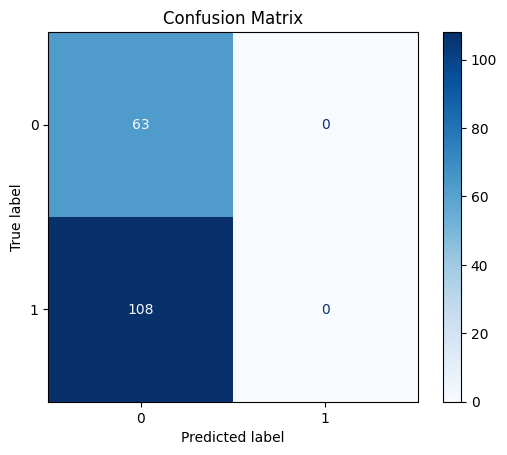

20:29:32.377 | INFO    | Task run 'confusion_matrix-0be' - Task 'confusion_matrix' completed in 0.08 seconds

20:29:32.393 | INFO    | Task run 'confusion_matrix-0be' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.37      1.00      0.54        63
           1       0.00      0.00      0.00       108

    accuracy                           0.37       171
   macro avg       0.18      0.50      0.27       171
weighted avg       0.14      0.37      0.20       171



c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

20:29:32.422 | INFO    | Task run 'show_classificationreport-0a0' - Task 'show_classificationreport' completed in 0.01 seconds

20:29:32.429 | INFO    | Task run 'show_classificationreport-0a0' - Finished in state Completed()

20:29:32.488 | INFO    | Flow run 'small-iguana' - Finished in state Completed()

In [20]:
@flow
def cancer_flow():
    dataset = cancer_dataset_retribution()
    X_train, X_test, y_train, y_test = cancer_preprocessing(dataset)

    class_names = ['0','1']

    dtree_model, y_pred = decision_tree(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, dtree_model, X_test, y_test)
    show_classificationreport(dtree_model, X_test, y_test, class_names)

    rf_model =random_forest(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, rf_model, X_test, y_test)
    show_classificationreport(rf_model, X_test, y_test, class_names)

    knn_model = knn(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, knn_model, X_test, y_test)
    show_classificationreport(knn_model, X_test, y_test, class_names)

    knn_scaled = knn_scaler(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, knn_scaled, X_test, y_test)
    show_classificationreport(knn_scaled, X_test, y_test, class_names)

    svm_class_model = svm(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, svm_class_model, X_test, y_test)
    show_classificationreport(svm_class_model, X_test, y_test, class_names)

    svm_class_scaled = svm_scaler(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, svm_class_scaled, X_test, y_test)
    show_classificationreport(svm_class_scaled, X_test, y_test, class_names)
cancer_flow()

20:30:05.410 | INFO    | Flow run 'big-kudu' - Beginning flow run 'big-kudu' for flow 'diabetes-flow'

Dataset cargado exitosamente.
   Embarazos  Glucosa  Presion Arterial  Grosor Piel  Insulina  \
0          1       85                66           29         0   
1          8      183                64            0         0   
2          1       89                66           23        94   
3          0      137                40           35       168   
4          5      116                74            0         0   

   Indice Masa Corporal  Función de Pedigree  Edad  Etiqueta  
0                  26.6                0.351    31         0  
1                  23.3                0.672    32         1  
2                  28.1                0.167    21         0  
3                  43.1                2.288    33         1  
4                  25.6                0.201    30         0  


20:30:05.575 | INFO    | Task run 'diabetes_dataset_retribution-09e' - Task 'diabetes_dataset_retribution' completed in 0.15 seconds

20:30:05.575 | INFO    | Task run 'diabetes_dataset_retribution-09e' - Finished in state Completed()

Tamaño de X_train: (536, 7)
Tamaño de y_train: (536,)
Tamaño de X_test: (231, 7)
Tamaño de y_test: (231,)


20:30:05.605 | INFO    | Task run 'diabetes_preprocessing-830' - Task 'diabetes_preprocessing' completed in 0.00 seconds

20:30:05.610 | INFO    | Task run 'diabetes_preprocessing-830' - Finished in state Completed()

Comparación de predicciones (primeras 5 filas):
     Embarazos  Insulina  Indice Masa Corporal  Edad  Glucosa  \
285          5       545                  38.7    34      155   
101          0         0                  22.5    21      125   
581         12         0                  26.5    62      121   
352          1        43                  27.2    24       90   
632          1       183                  27.5    22      128   

     Presion Arterial  Función de Pedigree  Etiqueta  Predicción  
285                84                0.619         0           1  
101                96                0.262         0           0  
581                78                0.259         0           1  
352                62                0.580         0           0  
632                82                0.115         0           0  
Resultados de la validación cruzada en decision tree:  [0.69 0.69 0.7  0.75 0.69]
Resultado promedio de la validación cruzada en decision tree: 0.7052440290758

20:30:05.667 | INFO    | Task run 'decision_tree-034' - Task 'decision_tree' completed in 0.03 seconds

20:30:05.672 | INFO    | Task run 'decision_tree-034' - Finished in state Completed()

0.700624241373331


20:30:05.707 | INFO    | Task run 'roc_curve_analysis-117' - Task 'roc_curve_analysis' completed in 0.01 seconds

20:30:05.707 | INFO    | Task run 'roc_curve_analysis-117' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[124  34]
 [ 28  45]]


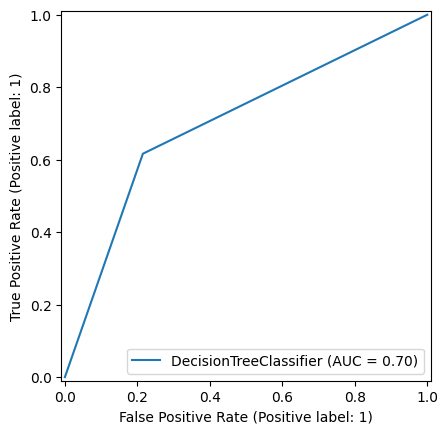

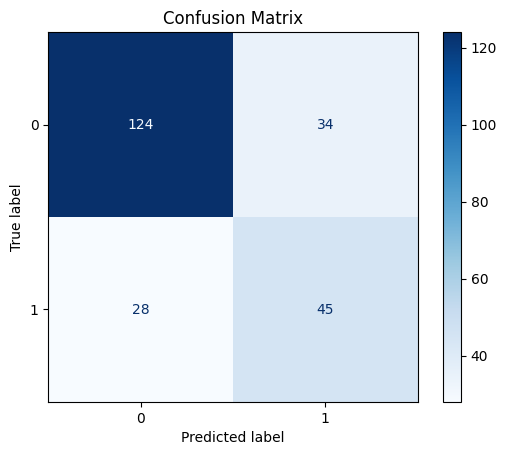

20:30:05.913 | INFO    | Task run 'confusion_matrix-159' - Task 'confusion_matrix' completed in 0.18 seconds

20:30:05.918 | INFO    | Task run 'confusion_matrix-159' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       158
           1       0.57      0.62      0.59        73

    accuracy                           0.73       231
   macro avg       0.69      0.70      0.70       231
weighted avg       0.74      0.73      0.73       231



20:30:05.956 | INFO    | Task run 'show_classificationreport-af3' - Task 'show_classificationreport' completed in 0.01 seconds

20:30:05.961 | INFO    | Task run 'show_classificationreport-af3' - Finished in state Completed()

Random Forest Accuracy: 0.7706


20:30:06.138 | INFO    | Task run 'random_forest-03a' - Task 'random_forest' completed in 0.15 seconds

20:30:06.143 | INFO    | Task run 'random_forest-03a' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[134  24]
 [ 29  44]]


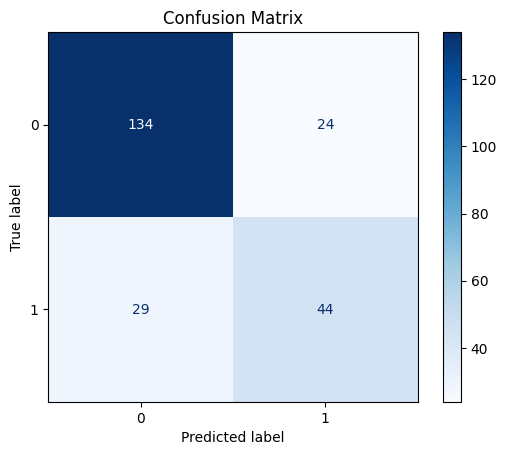

20:30:06.279 | INFO    | Task run 'confusion_matrix-8e5' - Task 'confusion_matrix' completed in 0.10 seconds

20:30:06.284 | INFO    | Task run 'confusion_matrix-8e5' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       158
           1       0.65      0.60      0.62        73

    accuracy                           0.77       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.77      0.77      0.77       231



20:30:06.339 | INFO    | Task run 'show_classificationreport-24f' - Task 'show_classificationreport' completed in 0.02 seconds

20:30:06.344 | INFO    | Task run 'show_classificationreport-24f' - Finished in state Completed()

Comparación de predicciones (primeras 5 filas):
     Embarazos  Insulina  Indice Masa Corporal  Edad  Glucosa  \
285          5       545                  38.7    34      155   
101          0         0                  22.5    21      125   
581         12         0                  26.5    62      121   
352          1        43                  27.2    24       90   
632          1       183                  27.5    22      128   

     Presion Arterial  Función de Pedigree  Etiqueta  Predicción  
285                84                0.619         0           1  
101                96                0.262         0           0  
581                78                0.259         0           0  
352                62                0.580         0           0  
632                82                0.115         0           0  
Score sobre el conjunto de test: 0.688
[0.72 0.67 0.72 0.74 0.63]
Desempeño promedio del kNN:
0.6958463136033229
Exactitud (accuracy) en prueba (testing) del k

20:30:06.405 | INFO    | Task run 'knn-b12' - Task 'knn' completed in 0.04 seconds

20:30:06.410 | INFO    | Task run 'knn-b12' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[117  41]
 [ 31  42]]


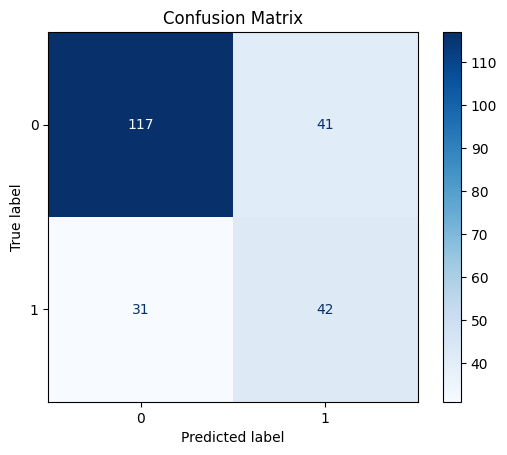

20:30:06.534 | INFO    | Task run 'confusion_matrix-1cd' - Task 'confusion_matrix' completed in 0.10 seconds

20:30:06.540 | INFO    | Task run 'confusion_matrix-1cd' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.79      0.74      0.76       158
           1       0.51      0.58      0.54        73

    accuracy                           0.69       231
   macro avg       0.65      0.66      0.65       231
weighted avg       0.70      0.69      0.69       231



20:30:06.574 | INFO    | Task run 'show_classificationreport-32e' - Task 'show_classificationreport' completed in 0.01 seconds

20:30:06.580 | INFO    | Task run 'show_classificationreport-32e' - Finished in state Completed()

Comparación de predicciones:
     Embarazos  Insulina  Indice Masa Corporal  Edad  Glucosa  \
285          5       545                  38.7    34      155   
101          0         0                  22.5    21      125   
581         12         0                  26.5    62      121   
352          1        43                  27.2    24       90   
632          1       183                  27.5    22      128   

     Presion Arterial  Función de Pedigree  Etiqueta  Predicción  
285                84                0.619         0           0  
101                96                0.262         0           0  
581                78                0.259         0           0  
352                62                0.580         0           0  
632                82                0.115         0           0  
Score sobre el conjunto de test: 0.710
[0.76 0.71 0.74 0.7  0.69]
Desempeño promedio:
0.7200761509172724
Exactitud (accuracy) en prueba (testing): 0.70995670995671


20:30:06.650 | INFO    | Task run 'knn_scaler-3e4' - Finished in state Completed()

Comparación de predicciones (primeras 5 filas):
     Embarazos  Insulina  Indice Masa Corporal  Edad  Glucosa  \
285          5       545                  38.7    34      155   
101          0         0                  22.5    21      125   
581         12         0                  26.5    62      121   
352          1        43                  27.2    24       90   
632          1       183                  27.5    22      128   

     Presion Arterial  Función de Pedigree  Etiqueta  Predicción  
285                84                0.619         0           1  
101                96                0.262         0           0  
581                78                0.259         0           0  
352                62                0.580         0           0  
632                82                0.115         0           0  
Score de entrenamiento: 0.757
Score de test: 0.784
Scores de validación cruzada:
[0.75 0.76 0.76 0.72 0.72]
Desempeño promedio:
0.7406542056074766
Accuracy en 

20:30:06.750 | INFO    | Task run 'svm-23e' - Task 'svm' completed in 0.07 seconds

20:30:06.756 | INFO    | Task run 'svm-23e' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[148  10]
 [ 40  33]]


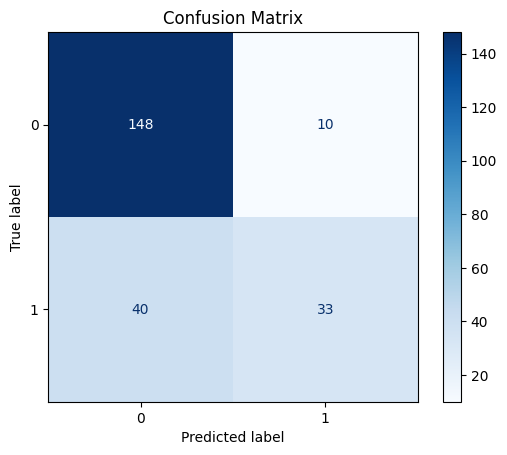

20:30:06.886 | INFO    | Task run 'confusion_matrix-79b' - Task 'confusion_matrix' completed in 0.11 seconds

20:30:06.887 | INFO    | Task run 'confusion_matrix-79b' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       158
           1       0.77      0.45      0.57        73

    accuracy                           0.78       231
   macro avg       0.78      0.69      0.71       231
weighted avg       0.78      0.78      0.76       231



20:30:06.923 | INFO    | Task run 'show_classificationreport-8b7' - Task 'show_classificationreport' completed in 0.01 seconds

20:30:06.929 | INFO    | Task run 'show_classificationreport-8b7' - Finished in state Completed()

Comparación de predicciones (primeras 5 filas):
     Embarazos  Insulina  Indice Masa Corporal  Edad  Glucosa  \
285          5       545                  38.7    34      155   
101          0         0                  22.5    21      125   
581         12         0                  26.5    62      121   
352          1        43                  27.2    24       90   
632          1       183                  27.5    22      128   

     Presion Arterial  Función de Pedigree  Etiqueta  Predicción  
285                84                0.619         0           1  
101                96                0.262         0           0  
581                78                0.259         0           0  
352                62                0.580         0           0  
632                82                0.115         0           0  
Score de entrenamiento: 0.821
Score de test: 0.736
Scores de validación cruzada:
[0.82 0.77 0.79 0.76 0.78]
Desempeño promedio:
0.7816372447213569
Accuracy en 

20:30:07.019 | INFO    | Task run 'svm_scaler-196' - Task 'svm_scaler' completed in 0.07 seconds

20:30:07.024 | INFO    | Task run 'svm_scaler-196' - Finished in state Completed()

20:30:07.050 | INFO    | Flow run 'big-kudu' - Finished in state Completed()

In [21]:
@flow
def diabetes_flow():
    dataset = diabetes_dataset_retribution()
    X_train, X_test, y_train, y_test = diabetes_preprocessing(dataset)

    class_names = ['0','1']

    dtree_model, y_pred = decision_tree(X_train, X_test, y_train, y_test)
    roc_curve_analysis(dtree_model, X_test, y_test, y_pred)
    confusion_matrix(class_names, dtree_model, X_test, y_test)
    show_classificationreport(dtree_model, X_test, y_test, class_names)

    rf_model =random_forest(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, rf_model, X_test, y_test)
    show_classificationreport(rf_model, X_test, y_test, class_names)

    knn_model = knn(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, knn_model, X_test, y_test)
    show_classificationreport(knn_model, X_test, y_test, class_names)

    knn_scaler(X_train, X_test, y_train, y_test)

    svm_class_model = svm(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, svm_class_model, X_test, y_test)
    show_classificationreport(svm_class_model, X_test, y_test, class_names)

    svm_scaler(X_train, X_test, y_train, y_test)
    
diabetes_flow()